# Remote Sensing in the Gulf of Guinea: Lesson 2

## _Reading multiple satellite images and making an animation/movie._

## Objective(s).

The student will learn how to display multiple images from a satellite, and save these images to file. The final objective is to make an animation that provides **qualitative understanding** of salinity dynamics in the Gulf of Guinea.

## Description.

This script reads in several netcdf files and displays the data.

The files have been downloaded from Remote Sensing Systems (http://www.remss.com/) and contain sea surface salinity (SSS), as well as a few other data products. As before, we look at SSS, zooming into a region on the Gulf of Guinea for educational purposes. We then plot this as a function of geographic location. These images are displayed sequentially, writing each image to file.

Challenge questions:
1.  How often does the salinity change in the Gulf of Guinea? Or rather, at a given location in the Gulf of Guinea, does it change every week? Month? Seasonally?
1.  Where does the salinity tend to change? Might you be able to link this to specific physical processes?
1.  If we were interested in salinity in another region of the world (say Brazil), how would we modify our code to display these regions?

Think about these questions as you are going through the lesson.

**Christian Buckingham & Eben Nyadjro**

<div class="alert alert-block alert-success">
<b>Quote:</b> If a picture is worth a thousand words, a movie is worth a million.
</div>

## Load a few important packages.

First, we load a few important packages. If you do not have these, and if you are using anaconda as your python distribution, type **`conda install xarray`** at the terminal window (MacOS, Linux) or command line (Windows). The conda manager package should download it from the internet. If you have installed python a different way, try **`pip install xarray`**.

In [1]:
## A few necessary packages.
import numpy as np
from netCDF4 import Dataset #Dataset, MFDataset
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import scipy.signal as signal
import os.path
import os.path
import datetime as dt
import calendar as calendar

/anaconda3/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)


## Read in several netcdf files.

As we __[learned earlier](Salinity_GulfOfGuinea_Lesson1.ipynb)__, NetCDF (.nc) files contain binary data in a format that contains not only the data themselves but also information that describes these data. We referred to this latter type of information as **metadata**.

Below, we use strings to tell Python where to find the file and we plot the data itself. Since we are already familiar with the file type, we will not worry about the metadata; that is, we will not display it to the screen.

One of the more difficult challenges here is defining the filenames for the files. Since there are (potentially) so many, we will not want to type these in directly. Rather, we will want to automate this step ... In just so happens that the filenames have a unique format. That is, they are always the same length and only change with the date of the file. Thus, we can define (create) the text string describing the filename by looping over specific dates. This is done below. We use fixed prefixes (beginning of the filename, such as **`RSS_smap_SSS_L3_8day_running_40km_`**) and suffixes (end of the filename, such as **`_FNL_v03.0.nc`**). We just need to change the date (the middle of the filename, such as **`2015_090`**).

In [2]:
# Define the files to be read.

# Define the base input directory.
basedirin = "/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/2015/" # main directory, remember the slash on the end of the pathname

# Define the base output directory.
basedirout = "/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/GoG/" # main directory, remember the slash on the end of the pathname

# Define the prefix, suffix, resolution and extension.
# The total filename will be ... fname = prefx + resolution + yyyy_ddd + suffx + ext
prefx = "RSS_smap_SSS_L3_8day_running"
suffx = "_FNL_v03.0"
resolution = "_40km_"
ext = ".nc"

years_of_interest = np.array([2015,2016,2017,2018])
nyear_of_interest = len(years_of_interest)

days_of_interest = np.arange(366) # add an extra day to handle leap years
nday_of_interest = len(days_of_interest) # this will be 366 but we loop only over the first 365 below

ifile = 0 # initialise this value
infiles = {}
infiles_time_yr = {}
infiles_time_dy = {}
for icounter in range(nyear_of_interest): # loop over years
    for jcounter in range(365): # loop over days
        
        yr = years_of_interest[icounter] # year
        dy = days_of_interest[jcounter] # day
        
        yyyy = str(yr) # string denoting year
        ddd = str(dy) # string denoting day
        
        # This part is a bit tricky because we need the numbers to look like
        # "001","002" ... "090" rather than "1","2" ... "90"
        # So we check to see what the value is, and add zeros in front.
        if (dy < 10.0):
            ddd = "00"+ddd
        elif (dy >= 10) & (dy < 100):
            ddd = "0"+ddd
        else:
            ddd = ddd
        
        yyyy_ddd = yyyy + "_" + ddd
        
        # Sometimes the folders have a subdirectory in the form of a "year".
        subdir = yyyy + "/" # subdirectory, remember the slash on the end of the pathname
        pname = basedirin + subdir
        
        # Sometimes no subdirectory.
        subdir = "" # subdirectory, remember the slash on the end of the pathname
        pname = basedirin
        fname = prefx + resolution + yyyy_ddd + suffx + ext
        
        infile = pname+fname
        #print(infile)
        #tmp = os.listdir(pname)
        #print(tmp)
        
        tmp = os.path.exists(infile)
        if tmp:
            
            # Print this to the screen for the user.
            # Store input filename in another variable.
            print(infile)
            infiles[ifile] = infile # store in a dictionary, if we want to access we type infiles[ifile]
            infiles_time_yr[ifile] = yr # store in a dictionary
            infiles_time_dy[ifile] = dy # store in a dictionary
            ifile = ifile + 1 # increment this variable
        

/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_090_FNL_v03.0.nc
/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_091_FNL_v03.0.nc
/Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_092_FNL_v03.0.nc


Now, we read in the netcdf files. In this case, we loop over each file and display it to the screen, saving each to an image file as we do so. As before, this uses a function called **`Dataset`** in the **`netCDF4`** package.

It would also be helpful to handle time a little differently--i.e. converting from yyyy_ddd to yyyy_mm_dd so that it is sensible when viewed in the animation. We do that below, using the **`datetime`** package.

Reading file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_090_FNL_v03.0.nc
Writing file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/GoG/Graphics/smap_2015_090.png


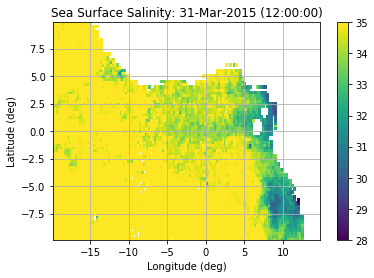

Reading file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_091_FNL_v03.0.nc
Writing file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/GoG/Graphics/smap_2015_091.png


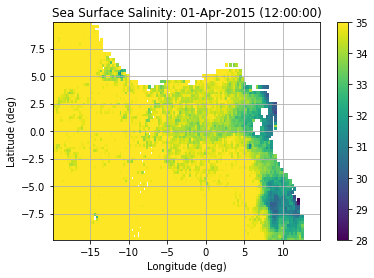

Reading file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/RSS_smap_SSS_L3_8day_running_40km_2015_092_FNL_v03.0.nc
Writing file ... /Users/ceb1c13/Dropbox/Data/2019-08-01-SMAP/GoG/Graphics/smap_2015_092.png


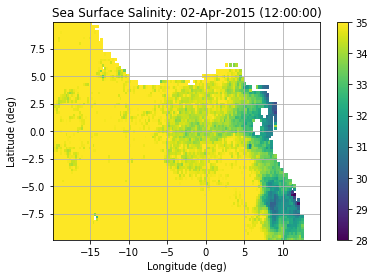

In [3]:
# Determine the number of files.
nfile = len(infiles)

# Now loop over each file and display.
for counter in range(nfile):
    
    #======================================================
    # Read file.
    
    infile = infiles[counter]
    yr = infiles_time_yr[counter]
    dy = infiles_time_dy[counter]
    print("Reading file ... " + infile)
    
    #======================================================
    # Read in the data from the netcdf file.
    # We use the netCDF4 package to read the netcdf file.
    
    nc = Dataset(infile, "r")
    etime = nc.variables["time"][:] # time in seconds since 2000/01/00 00:00
    lat = nc.variables["lat"][:] # latitude (degrees), values = [-90, 90]
    lon = nc.variables["lon"][:] # longitude (degrees), values = [0, 360]
    nobs = nc.variables["nobs"][:] # Number of observations for L3 average (unitless)
    sss_smap = nc.variables["sss_smap"][:] # sea_surface_salinity (practical salinity units == unitless)
    sst_ref = nc.variables["surtep"][:] # Ancillary sea surface temperature (from Canada Meteorological Center), doi: 10.5067/GHCMC-4FM03
    
    # Access the "data" portion of the variable, as python handles this as a masked array.
    etime = etime.data
    lat = lat.data
    lon = lon.data
    sss = sss_smap.data
    
    # Convert some variables to double precision (float64).
    lat = np.double(lat)
    lon = np.double(lon)
    sss = np.double(sss)
    
    nlat = len(lat)
    nlon = len(lon)
    sdata = sss.shape
    
    # Simple manner of handling time.
    dtime = etime/86400 # convert seconds to days since ...
    
    #======================================================
    # Subset for the region of interest.
    
    latlim = np.array([-10.0,10.0])
    lonlim = np.array([-20.0,15.0])
    latlim = np.double(latlim)
    lonlim = np.double(lonlim)
    ilat1 = (lat >= latlim[0]) & (lat <= latlim[1])
    ilon1 = ((lon-360.0) >= lonlim[0]) & ((lon-360.0) < 0.);
    ilon2 = (lon >= 0) & (lon <= lonlim[1])
    ilat = ilat1;
    ilon = np.concatenate((ilon1,ilon2), axis=0)
    
    lats = lat[ilat1]
    lons1 = lon[ilon1] - 360
    lons2 = lon[ilon2]
    lons = np.concatenate((lons1,lons2), axis=0)
    
    index1 = np.array(np.where(ilat))
    index2 = np.array(np.where(ilon))
    #print(index1)
    #print(index2)
    sss_block1 = sss[ilat,:]
    sss_block1 = sss_block1[:,ilon1]
    sss_block2 = sss[ilat,:]
    sss_block2 = sss_block2[:,ilon2]
    
    nlats = len(lats)
    nlons = len(lons)
    nlons1 = len(lons1)
    nlons2 = len(lons2)
    sss_block = np.zeros([nlats,nlons])
    sss_block[0:nlats,0:nlons1] = sss_block1
    sss_block[0:nlats,nlons1:nlons1+nlons2] = sss_block2
    
    #======================================================
    # Form a mask for the land.
    # This mask uses the bad salinity values to identify land.
    mask = np.zeros([nlats,nlons])
    igood = (sss_block >= 10) # find good salinity values
    mask[igood] = 1
    inan = (sss_block < 10) # find bad values
    mask[inan] = np.nan # not a number
    
    #======================================================
    # Plot the salinity.
    yyyy = str(yr)
    ddd = str(dy)
    time_str = yyyy + "_" + ddd
    
    # Handle the time information.
    reftime = dt.datetime(2000,1,1,0,0,0) # define reference time using "datetime" package    
    time_info = np.array([ reftime + dt.timedelta(days=dtime[ii]) for ii in range(len(dtime)) ])
    time_str = dt.datetime.strftime(time_info[0],"%d-%b-%Y (%H:%M:%S)")
    #time_str = dt.datetime.strftime(time_info[0],"%d-%b-%Y (%H:%M:%S.%f)")
    
    plt.pcolor(lons,lats,sss_block*mask)
    plt.clim(28,35)
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    plt.title('Sea Surface Salinity: '+ time_str)# here we need to insert a date inside the brackets
    plt.grid()
    plt.colorbar()
    
    # Note that we had to get rid of the plt.show() command.
    # Please ask Dr. Paige why this is.
    
    #======================================================
    # Create text for the output filename.
    
    yyyy = str(yr)
    ddd = str(dy)
    if (dy < 10.0):
        ddd = "00"+ddd
    elif (dy >= 10) & (dy < 100):
        ddd = "0"+ddd
    else:
        ddd = ddd
    
    yyyy_ddd = yyyy + "_" + ddd
    
    # Print image to file.
    outdir = basedirout + "Graphics/"
    outfile = outdir+'smap_'+ yyyy_ddd + '.png'
    #outfile = outdir+'smap_'+ yyyy_ddd + str(counter)+'.png'
    print("Writing file ... " + outfile)
    plt.savefig(outfile,format='png',dpi=300)
    
    plt.pause(1) # time.sleep(0.5)

As __[before](Salinity_GulfOfGuinea_Lesson1.ipynb)__, **there seems to be a lot of low-salinity water (fresh water) emanating from the coastline and which is likely due to the Congo and Niger rivers.**

The next thing we need to do is take all of these images and make a movie. For the MacOS, I use a program called **_Image2Movie_** written by Jeff Early. For the PC, you can try a program called **_VideoMach_**. I'm not sure how Linux programs do this but it is probably even easier. Note: the software must be able to handle .png images.

After making the movie with 3 images, together as a team, we will make a movie with **all of the images**. That's over 4 years of data!

**In the __[final lesson](Salinity_GulfOfGuinea_Lesson3.ipynb)__, we will examine the satellite data at a single location to see if there is a seasonal signal in SSS.** The region that will be selected is just outside the Congo River (i.e. latitude = -6 deg, longitude = +7 deg), although the user may change this location as desired.